In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
#from tensorflow.keras.optimizers import *
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
import datetime
import seaborn as sns
import tensorflow as tf
import matplotlib.dates as mdates
import requests
## timestamp dependencies
from datetime import datetime

## visualisation dependencies
import matplotlib.pyplot as plt
# series = pd.read_csv('data.csv')

url = 'http://209.38.208.230:8000/api/posts/?date_range=year&dev=sm-0006'
response=requests.get(url).json()
df1=pd.DataFrame(response)

series = df1[['created', 'value']]

series.drop_duplicates(subset='created', inplace=True)
series['created'] = pd.to_datetime(series['created'])

date_time = pd.to_datetime(series.pop('created'), format='%d.%m.%Y %H:%M:%S')

timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

series['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
series['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
# series['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# series['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

column_indices = {name: i for i, name in enumerate(series.columns)}

n = len(series)
train_df = series[0:int(n*0.7)]
val_df = series[int(n*0.7):int(n*0.9)]
test_df = series[int(n*0.9):]

num_features = series.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std

val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std



df_std = (series - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

C:\Users\Georgi Manev\AppData\Local\Temp\ipykernel_1736\339961628.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.drop_duplicates(subset='created', inplace=True)
C:\Users\Georgi Manev\AppData\Local\Temp\ipykernel_1736\339961628.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series['created'] = pd.to_datetime(series['created'])
C:\Users\Georgi Manev\AppData\Local\Temp\ipykernel_1736\339961628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
          labels = tf.stack(
              [labels[:, :, self.column_indices[name]] for name in self.label_columns],
              axis=-1
          )
      inputs.set_shape([None, self.input_width, None])
      labels.set_shape([None, self.label_width, None])
      return inputs, labels
  
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds 

  def plot(self, model=None, plot_col='value', max_subplots=3):
      inputs, labels = self.example
      plt.figure(figsize=(12, 8))
      plot_col_index = self.column_indices[plot_col]
      max_n = min(max_subplots, len(inputs))
      x = self.train_df.index  # Assuming the index represents the date and time

      for n in range(max_n):
          plt.subplot(max_n, 1, n+1)
          plt.ylabel(f'{plot_col} [normed]')
          plt.plot(x[self.input_indices], inputs[n, :, plot_col_index],
                  label='Inputs', marker='.', zorder=-10)

          if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
          else:
              label_col_index = plot_col_index

          if label_col_index is not None:
              plt.scatter(x[self.label_indices], labels[n, :, label_col_index],
                          edgecolors='k', label='Actual', c='#2ca02c', s=64)

          if model is not None:
              predictions = model(inputs)
              prediction_col_index = self.label_columns_indices.get(plot_col, None)
              if prediction_col_index is not None:
                  plt.scatter(x[self.label_indices], predictions[n, :, prediction_col_index],
                              marker='X', edgecolors='k', label='Predictions',
                              c='#ff7f0e', s=64)

          if n == 0:
              plt.legend()

      plt.xlabel('Date and Time')
      plt.xticks(rotation=45)
      plt.show()


In [20]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [21]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [22]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['value'])


Epoch 1/50
42/42 [==============================] - 5s 28ms/step - loss: 0.6538 - mean_absolute_error: 0.6314 - val_loss: 0.3917 - val_mean_absolute_error: 0.5335
Epoch 2/50
42/42 [==============================] - 1s 16ms/step - loss: 0.3215 - mean_absolute_error: 0.4475 - val_loss: 0.3451 - val_mean_absolute_error: 0.4884
Epoch 3/50
42/42 [==============================] - 1s 17ms/step - loss: 0.2246 - mean_absolute_error: 0.3644 - val_loss: 0.2867 - val_mean_absolute_error: 0.4447
Epoch 4/50
42/42 [==============================] - 1s 17ms/step - loss: 0.1772 - mean_absolute_error: 0.3212 - val_loss: 0.2200 - val_mean_absolute_error: 0.3835
Epoch 5/50
42/42 [==============================] - 1s 17ms/step - loss: 0.1462 - mean_absolute_error: 0.2903 - val_loss: 0.1922 - val_mean_absolute_error: 0.3581
Epoch 6/50
42/42 [==============================] - 1s 17ms/step - loss: 0.1254 - mean_absolute_error: 0.2686 - val_loss: 0.1496 - val_mean_absolute_error: 0.3106
Epoch 7/50
42/42 [====

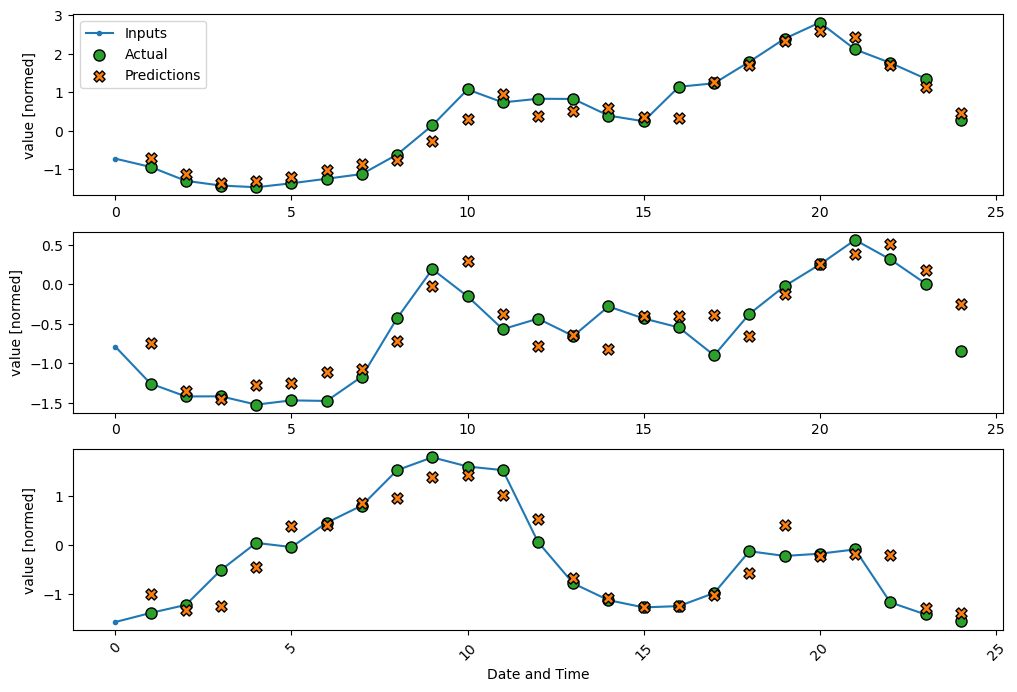

In [23]:
history = compile_and_fit(lstm_model, wide_window)

#Plot the predictions to check accuracy
wide_window.plot(lstm_model)


6/6 [==============================] - 0s 5ms/step


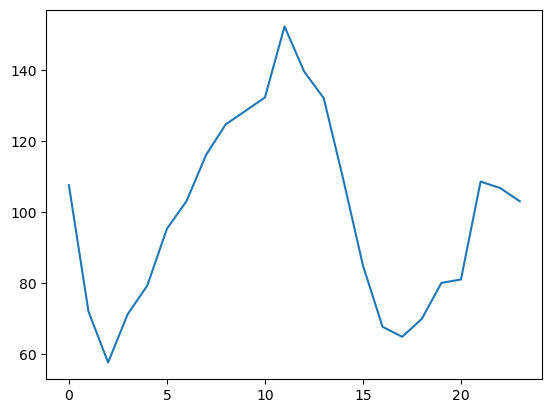

In [25]:
prediction_data = wide_window.make_dataset(test_df)
predictions = lstm_model.predict(prediction_data)
predictions_original = (predictions * train_std['value']) + train_mean['value']

plt.plot(predictions_original[0])

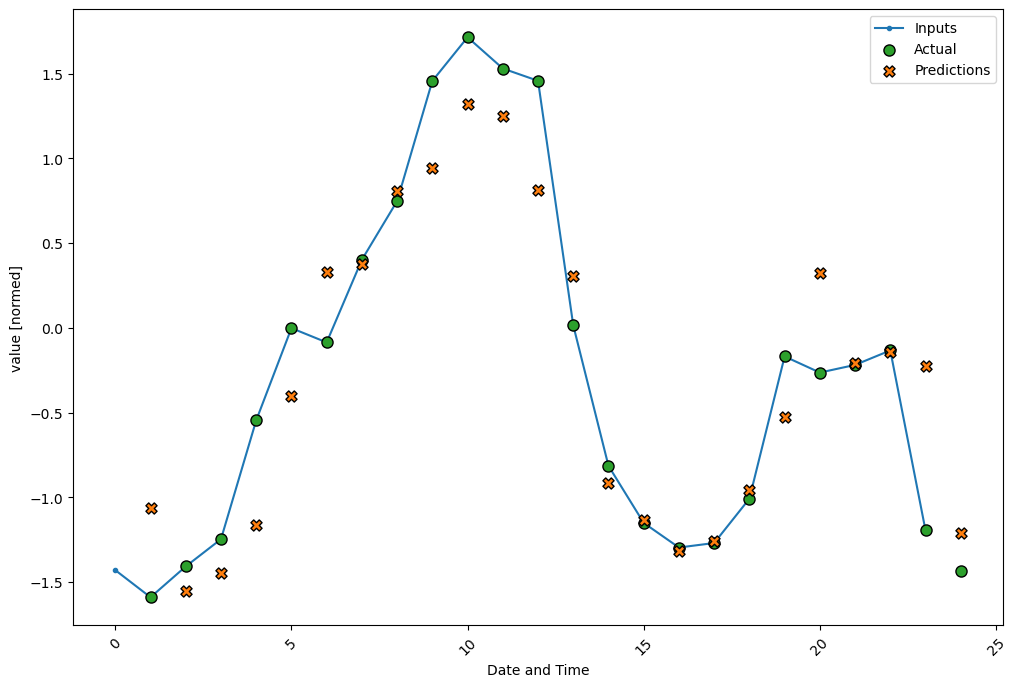

In [8]:
#Predictions vs train_df
wide_window.plot(lstm_model, plot_col='value', max_subplots=1)

#wide_window.plot(plot_col='value', max_subplots=1)
